In [4]:
!pip install catboost

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
# Load the dataset
file_path = "Synthetic_Data_For_Students.csv"
df = pd.read_csv(file_path)

In [3]:
# Display/Inspect basic info
print("First few rows:")
print(df.head())

print("\nColumn names:")
print(df.columns)

print("\nMissing values:")
print(df.isnull().sum())

First few rows:
   SettlementValue                             AccidentType Injury_Prognosis  \
0            520.0                                 Rear end      E. 5 months   
1            870.0                                 Rear end      B. 2 months   
2           2140.0       Other side pulled out of side road      G. 7 months   
3            520.0  Rear end - Clt pushed into next vehicle      D. 4 months   
4            260.0                                 Rear end      C. 3 months   

   SpecialHealthExpenses  SpecialReduction  SpecialOverage  GeneralRest  \
0                    0.0               0.0             0.0          0.0   
1                    0.0               0.0             0.0        520.0   
2                    0.0               0.0             0.0       1400.0   
3                    0.0               0.0             0.0          0.0   
4                    0.0               0.0             0.0          0.0   

   SpecialAdditionalInjury  SpecialEarningsLoss  Spe

In [4]:
# Before filling missing features drop missing target feature rows
df = df.dropna(subset=['SettlementValue'])

In [5]:
# Handle Missing Values

# Fill numerical missing values with median
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical missing values with mode
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].apply(lambda x: x.fillna(x.mode()[0]))

print("\nMissing values after handling:")
print(df.isnull().sum())


Missing values after handling:
SettlementValue               0
AccidentType                  0
Injury_Prognosis              0
SpecialHealthExpenses         0
SpecialReduction              0
SpecialOverage                0
GeneralRest                   0
SpecialAdditionalInjury       0
SpecialEarningsLoss           0
SpecialUsageLoss              0
SpecialMedications            0
SpecialAssetDamage            0
SpecialRehabilitation         0
SpecialFixes                  0
GeneralFixed                  0
GeneralUplift                 0
SpecialLoanerVehicle          0
SpecialTripCosts              0
SpecialJourneyExpenses        0
SpecialTherapy                0
Exceptional_Circumstances     0
Minor_Psychological_Injury    0
Dominant injury               0
Whiplash                      0
Vehicle Type                  0
Weather Conditions            0
Accident Date                 0
Claim Date                    0
Vehicle Age                   0
Driver Age                    0
Number o

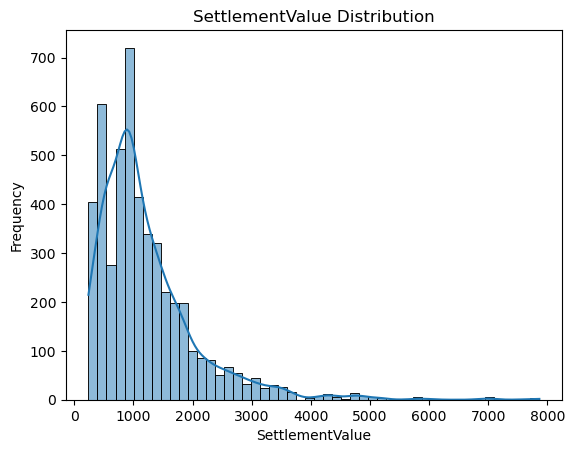

Skewness: 2.30
Highly positively skewed (right-skewed).


In [6]:
# Check for skewedness 

# 1. Quick visual inspection
sns.histplot(df['SettlementValue'], bins=50, kde=True)
plt.title("SettlementValue Distribution")
plt.xlabel("SettlementValue")
plt.ylabel("Frequency")
plt.show()

# 2. Calculate skewness
skewness = stats.skew(df['SettlementValue'])
print(f"Skewness: {skewness:.2f}")

# 3. Interpretation
if skewness > 1:
    print("Highly positively skewed (right-skewed).")
elif skewness < -1:
    print("Highly negatively skewed (left-skewed).")
elif 0.5 < skewness <= 1 or -1 <= skewness < -0.5:
    print("Moderately skewed.")
else:
    print("Fairly symmetric.")


In [7]:
# Log transformation if highly skewed
if skewness > 1 or skewness < -1:
    print("Applying log transformation to 'SettlementValue' due to high skewness.")
    df['SettlementValue'] = np.log1p(df['SettlementValue'])

Applying log transformation to 'SettlementValue' due to high skewness.


Create 'Days_To_Claim' column to help capture a useful time-based signal.

In [8]:
# Process Date Features
# If the dataset contains date columns (e.g., Accident Date, Claim Date), extract useful features:

# Clean up column names by stripping extra spaces
df.columns = df.columns.str.strip()

# Convert to datetime
df['Accident Date'] = pd.to_datetime(df['Accident Date'], errors='coerce')
df['Claim Date'] = pd.to_datetime(df['Claim Date'], errors='coerce')

# Create feature: Days between accident and claim
df['Days_To_Claim'] = (df['Claim Date'] - df['Accident Date']).dt.days

# Debugging: Check columns before attempting to drop
print("\nColumns before dropping:")
print(df.columns)

# Drop original date columns if they exist
if 'Accident Date' in df.columns and 'Claim Date' in df.columns:
    df = df.drop(columns=['Accident Date', 'Claim Date'])
    print("\nColumns after dropping:")
    print(df.columns)
else:
    print("Columns to drop not found.")
    
# Debugging: Check column existence again
if 'Accident Date' in df.columns and 'Claim Date' in df.columns:
    print("\nIn Dataset.")
else:
    print("\nNot In Dataset.")


Columns before dropping:
Index(['SettlementValue', 'AccidentType', 'Injury_Prognosis',
       'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage',
       'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss',
       'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage',
       'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed',
       'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts',
       'SpecialJourneyExpenses', 'SpecialTherapy', 'Exceptional_Circumstances',
       'Minor_Psychological_Injury', 'Dominant injury', 'Whiplash',
       'Vehicle Type', 'Weather Conditions', 'Accident Date', 'Claim Date',
       'Vehicle Age', 'Driver Age', 'Number of Passengers',
       'Accident Description', 'Injury Description', 'Police Report Filed',
       'Witness Present', 'Gender', 'Days_To_Claim'],
      dtype='object')

Columns after dropping:
Index(['SettlementValue', 'AccidentType', 'Injury_Prognosis',
       'SpecialHealthExpenses', 'SpecialRedu

In [9]:
# Ecode Categorical Variables (to convert text labels into numbers)

# REMOVED: USING CATBOOST ENCODING INSTEAD
# from sklearn.preprocessing import LabelEncoder

# label_encoders = {}
# for col in cat_cols:
#     if col in df.columns:  # Ensure the column still exists
#         le = LabelEncoder()
#         df[col] = le.fit_transform(df[col])
#         label_encoders[col] = le
#     else:
#         print(f"Column '{col}' not found in the DataFrame.")
#         print("Categorical columns:", cat_cols)

In [10]:
# Split Data into Train/Test Sets

from sklearn.model_selection import train_test_split

In [11]:
# Separate features and target variable
X = df.drop(columns=['SettlementValue'])  # Replace with correct target column name
y = df['SettlementValue']

In [12]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (3915, 34)
Testing data shape: (979, 34)


In [13]:
# Get list of categorical feature indices (for catBoost encoding)
cat_features = [i for i, col in enumerate(X_train.columns) if col in cat_cols]

In [14]:
# Train a Gradient Boosting Model

# (Pick one algorithm (e.g., CatBoost))
# Train the model
model = CatBoostRegressor(
    # iterations=500,
    iterations=50,
    depth=8, 
    learning_rate=0.2, 
    # l2_leaf_reg=2,
    l2_leaf_reg=4,
    loss_function='RMSE', 
    verbose=100
)

# Use cross_validate to handle the categorical features correctly
cv_results = cross_validate(
    model,
    X_train,
    y_train,
    cv=5,
    scoring='neg_root_mean_squared_error',
    return_train_score=False,
    fit_params={'cat_features': cat_features}
)

# Output the cross-validation results
best_score = model.get_best_score()
print("\nCross-validation RMSE scores (negative):", cv_results['test_score'])
print(f"Average RMSE from Cross-Validation: {-cv_results['test_score'].mean():.2f}")
    
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), early_stopping_rounds=50)

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


0:	learn: 0.5644856	total: 55.2ms	remaining: 2.7s
49:	learn: 0.2051183	total: 254ms	remaining: 0us
0:	learn: 0.5664800	total: 3.96ms	remaining: 194ms
49:	learn: 0.2086440	total: 182ms	remaining: 0us
0:	learn: 0.5666497	total: 4.02ms	remaining: 197ms
49:	learn: 0.1995325	total: 235ms	remaining: 0us
0:	learn: 0.5595352	total: 3.8ms	remaining: 186ms
49:	learn: 0.2062535	total: 175ms	remaining: 0us
0:	learn: 0.5598920	total: 4.06ms	remaining: 199ms
49:	learn: 0.1960097	total: 184ms	remaining: 0us

Cross-validation RMSE scores (negative): [-0.22556266 -0.21700645 -0.23694006 -0.24043082 -0.2357742 ]
Average RMSE from Cross-Validation: 0.23
0:	learn: 0.5678679	test: 0.5637719	best: 0.5637719 (0)	total: 4.29ms	remaining: 210ms
49:	learn: 0.1984512	test: 0.2017439	best: 0.2017439 (49)	total: 211ms	remaining: 0us

bestTest = 0.2017439302
bestIteration = 49



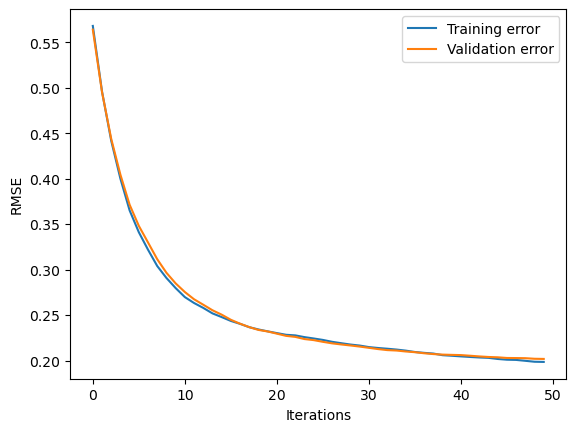

In [15]:
import matplotlib.pyplot as plt
plt.plot(model.get_evals_result()['learn']['RMSE'], label="Training error")
plt.plot(model.get_evals_result()['validation']['RMSE'], label="Validation error")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.show()

In [16]:
# Make predictions
y_pred = model.predict(X_test)

In [27]:
# Evaluate the model: RMSE, MAE, and R2
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# Calculate R2 (Coefficient of Determination)
ss_total = np.sum((y_test - np.mean(y_test))**2)  # Total sum of squares
ss_residual = np.sum((y_test - y_pred)**2)  # Residual sum of squares
r2 = 1 - (ss_residual / ss_total)

# Calculate and print the statistics for 'SettlementValue'
print("SettlementValue Summary:")
print("Average SettlementValue:", df['SettlementValue'].mean())
print("Minimum SettlementValue:", df['SettlementValue'].min())
print("Maximum SettlementValue:", df['SettlementValue'].max())
print("Standard Deviation of SettlementValue:", df['SettlementValue'].std())

print("Relative RMSE (% of mean SettlementValue):", (rmse / df['SettlementValue'].mean()) * 100)

# Print the model evaluation results
print(f"\nModel Evaluation:")
# (how far off predictions are on average)
print(f"RMSE: {rmse:.2f}")
# (on average, how much the model is off by (absolute error))
print(f"MAE: {mae:.2f}")
# (how well your model explains the variation in the target variable. A higher value (closer to 1) is better.)
print(f"R2: {r2:.4f}")

SettlementValue Summary:
Average SettlementValue: 6.898649760919735
Minimum SettlementValue: 5.484796933490655
Maximum SettlementValue: 8.970037945571177
Standard Deviation of SettlementValue: 0.6507045866395493
Relative RMSE (% of mean SettlementValue): 2.924397357077672

Model Evaluation:
RMSE: 0.20
MAE: 0.13
R2: 0.9009


# Indicators of Overfitting?

Learning Progress (Training Logs):
The training logs show consistent improvements from the start to the 49th iteration. The learn value (likely representing the loss or error) consistently decreases as the iterations progress, suggesting that the model is learning and converging.
The learn value decreases from around 0.564 to 0.199, showing a significant reduction in error. This suggests that the model is improving throughout the training process.

Cross-Validation RMSE Scores:
Negative RMSE values in cross-validation: These are reported as negative because of the scoring convention used (i.e., negative values indicate better performance). The actual RMSE values would be the positive counterparts, so the RMSE values range from 0.217 to 0.240, with an average of 0.23.
This is a reasonable range for RMSE, indicating that the model is making predictions with moderate accuracy. A lower RMSE means a better fit, but the absolute value is context-dependent on the problem and dataset.

Test Set Performance:
The test RMSE is reported as 0.20, which indicates the model's performance on the unseen data. Since the test RMSE is close to the average cross-validation RMSE (0.23), this suggests that the model is generalizing well without significant overfitting or underfitting.
The bestTest = 0.2017439302 and bestIteration = 49 values indicate that the model reached its best performance at iteration 49, which aligns with the early stopping point. This shows that stopping at 50 iterations was a reasonable choice, as the model did not seem to improve much beyond that.

SettlementValue Summary:
The mean settlement value is 6.90, with a standard deviation of 0.65, which is relatively moderate. The relative RMSE of 2.92% indicates that the model's error, relative to the mean settlement value, is quite low. This suggests that the model’s predictions are quite precise with respect to the average value, further supporting that overfitting or underfitting is unlikely.

Evaluation Metrics:
RMSE: 0.20 (excellent, indicates good performance).
MAE: 0.13 (also quite low, indicating that on average the model's predictions are off by just 0.13).
R2: 0.9009 (very high R2 value, indicating that about 90% of the variance in the data is explained by the model, which is excellent).

Conclusion:
Good Performance: The model seems to be performing well overall, with good accuracy, low error, and a high R2 value, indicating that it's explaining a large portion of the variance in the data.
Avoiding Overfitting and Underfitting: Given the test RMSE and the fact that the learning curves have stabilized by iteration 49, the model is not overfitting. It seems to have stopped improving at the right point, preventing overfitting while maintaining a reasonable level of predictive accuracy.
Model Stability: The performance on both the training and test sets, along with the validation scores, shows that the model is generalizing well, meaning it has avoided underfitting as well.

Final Thoughts:
These results appear good and balanced, with no signs of overfitting or underfitting. Based on the current output, the model seems ready for use.

# Is the Model Underfitting?

The learning curves start to diverge around the 45-50 iteration mark and stops at 50 iterations to avoid overfitting, making a reasonable trade-off based on the observation that past this point, the model starts to overfit. 
Is this a good model for real-world use?

Cross-Validation Results:
RMSE of 0.23 and an R2 of 0.9009 are strong indicators that the model is performing well on unseen data.
The Cross-Validation RMSE scores range between 0.22 and 0.24, which suggests that the model is stable and doesn't fluctuate drastically between different folds, reducing concerns about high variance.

Learning Curves:
If the learning curves are diverging at iteration 50, and it is stopped before the model overfits, this is a smart way to avoid overfitting.
Stopping early at iteration 50 (before the divergence) is a common strategy to prevent overfitting when the learning curves indicate the model is reaching its optimal fit at this point.
The fact that the training and validation errors are relatively close suggests that the model has learned well without overfitting.

Real-World Use Consideration:
Generalization: Based on the metrics (RMSE, R², and cross-validation results), it seems the model generalizes well to unseen data, which is crucial for real-world applications.
No clear signs of underfitting: The model's performance on both training and validation data suggests that it's not underfitting. The average RMSE is relatively low, and the R² score (0.9009) indicates good predictive power.

Divergence and Overfitting:
The differing learning curves after 50 iterations suggest that further training would likely result in the model memorizing the training data (overfitting), which can degrade its performance on new, unseen data.
Stopping at 50 iterations seems to be a safe stopping point based on the analysis of the learning curves, balancing the need to avoid overfitting with achieving a good fit.

## Final Assessment
Yes, this model is likely a good candidate for real-world use, as it meets the following criteria:
Good generalization: The model performs well on cross-validation, showing stability and a strong predictive ability on unseen data.
Avoidance of overfitting: Stopping training before overfitting starts ensures that the model does not memorize the training data, maintaining its ability to generalize.
Balanced performance: The metrics (RMSE, R²) suggest that the model strikes a good balance between bias and variance.

## Recommendations to Companies before/during Commercial Use
Test on Additional Data: If possible, try evaluating the model on a fresh, completely unseen test set before use to further confirm its generalization ability.
Monitor Real-World Performance: Over time, you could monitor the model’s performance as it’s deployed, ensuring it doesn't degrade with new data or under real-world conditions.
Periodic Retraining: If the model starts to degrade with new data over time, periodic retraining with updated data can help maintain its performance.

In summary, if the model’s performance is stable and it is neither overfitting nor underfitting (based on the cross-validation results), stopping at 50 iterations is a reasonable and effective strategy. The model appears to be in good shape for real-world deployment.

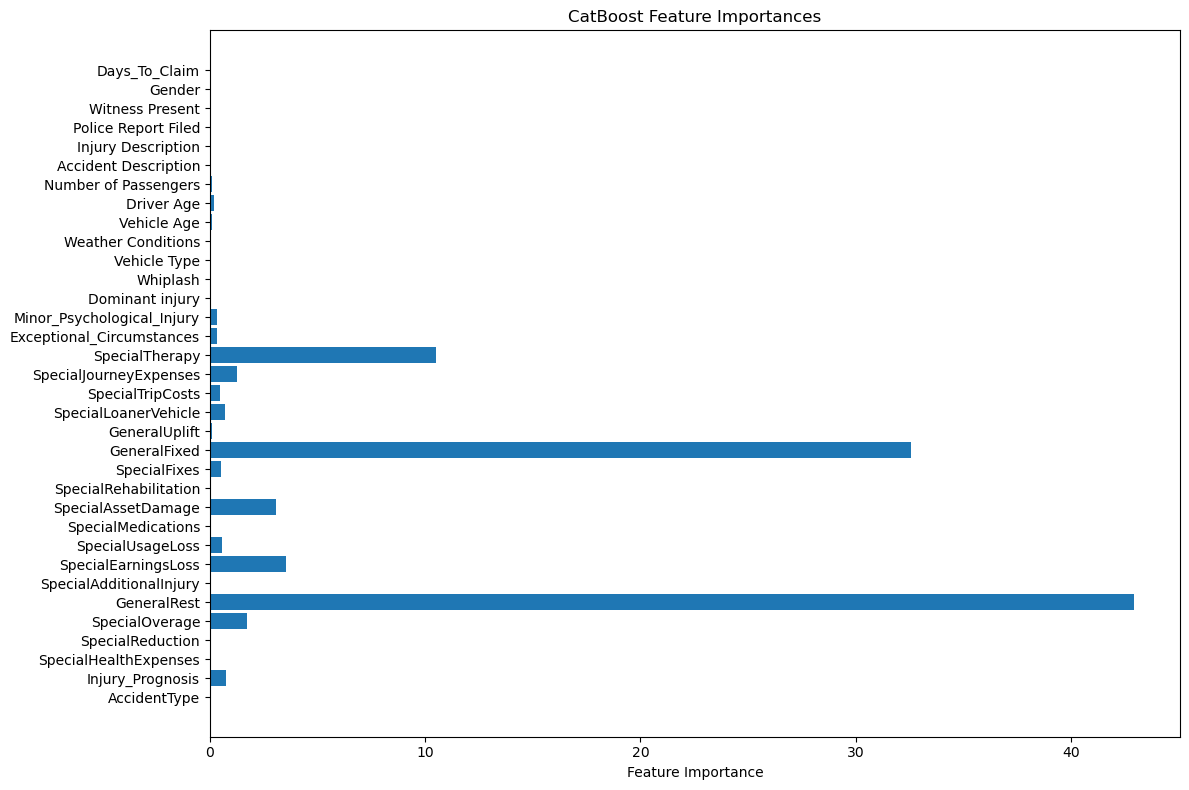

In [18]:
# Plot Feature Importances
feature_importances = model.get_feature_importance()
feature_names = X.columns

plt.figure(figsize=(12, 8))
plt.barh(feature_names, feature_importances)
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importances")
plt.tight_layout()
plt.show()

In [28]:
# ---------------------------------
# GeneralRest Feature Side-by-Side Model Comparison
# ---------------------------------

# # Create full feature set
# X_full = df.drop(columns=['SettlementValue'])
# y = df['SettlementValue']

# # Create reduced feature set (without GeneralRest)
# X_reduced = X_full.drop(columns=['GeneralRest']) if 'GeneralRest' in X_full.columns else X_full.copy()

# # Split both datasets
# X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y, test_size=0.2, random_state=42)
# X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# # Train Model 1: With GeneralRest
# model_full = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=0)
# model_full.fit(X_train_full, y_train_full, cat_features=cat_features, eval_set=(X_test_full, y_test_full), early_stopping_rounds=50)

# # Train Model 2: Without GeneralRest
# cat_features_reduced = [col for col in cat_features if col in X_reduced.columns]

# model_reduced = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=0)
# model_reduced.fit(X_train_reduced, y_train_reduced, cat_features=cat_features_reduced, eval_set=(X_test_reduced, y_test_reduced), early_stopping_rounds=50)

# # Evaluate both models
# def evaluate(model, X_test, y_test, label):
#     y_pred = model.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred)
#     rmse = np.sqrt(mse)
#     r2 = model.score(X_test, y_test)
#     print(f"\n📊 {label}:")
#     print(f"  RMSE: {rmse:.2f}")
#     print(f"  R2: {r2:.4f}")
#     return rmse, r2

# rmse_full, r2_full = evaluate(model_full, X_test_full, y_test_full, "Model WITH GeneralRest")
# rmse_reduced, r2_reduced = evaluate(model_reduced, X_test_reduced, y_test_reduced, "Model WITHOUT GeneralRest")

# # Plot Feature Importances
# importances_full = model_full.get_feature_importance()
# importances_reduced = model_reduced.get_feature_importance()

# features_full = X_full.columns
# features_reduced = X_reduced.columns

# fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# axs[0].barh(features_full, importances_full)
# axs[0].set_title("Feature Importances (WITH GeneralRest)")

# axs[1].barh(features_reduced, importances_reduced)
# axs[1].set_title("Feature Importances (WITHOUT GeneralRest)")

# plt.tight_layout()
# plt.show()

RMSE got a lot worse (jumped from ~377 ➔ ~519).
R2 dropped significantly (from 81.5% ➔ 65.0%).
Based on these results, GeneralRest is critical for the model and should not be dropped.
It is genuinely helping the model make better predictions — not just "taking credit" falsely.

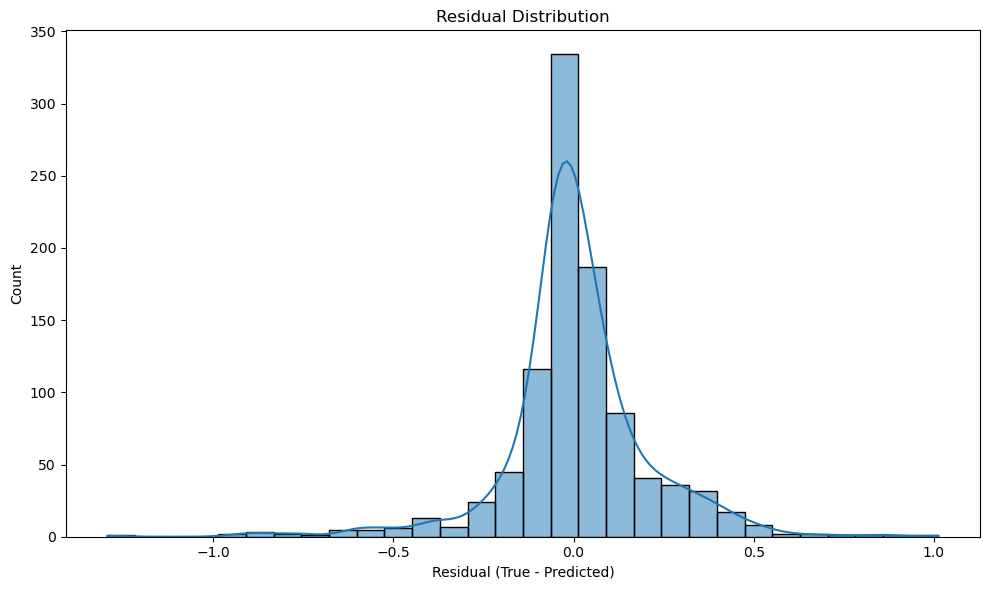

In [20]:
# Plot Residuals
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual (True - Predicted)")
plt.tight_layout()
plt.show()

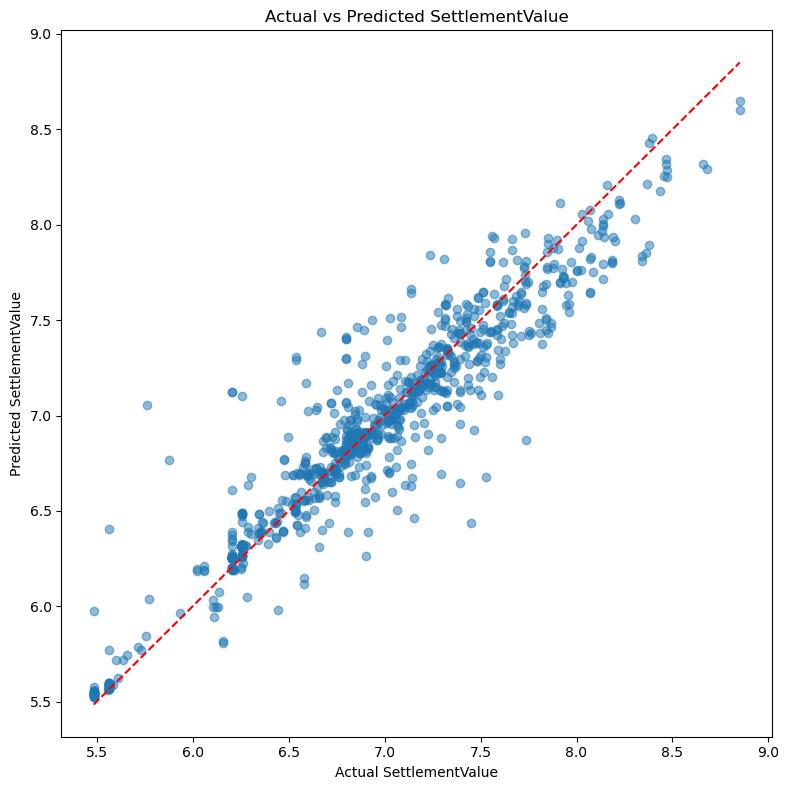

In [21]:
# Scatter Plot to check prediction bias or spread
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.xlabel('Actual SettlementValue')
plt.ylabel('Predicted SettlementValue')
plt.title('Actual vs Predicted SettlementValue')
plt.tight_layout()
plt.show()


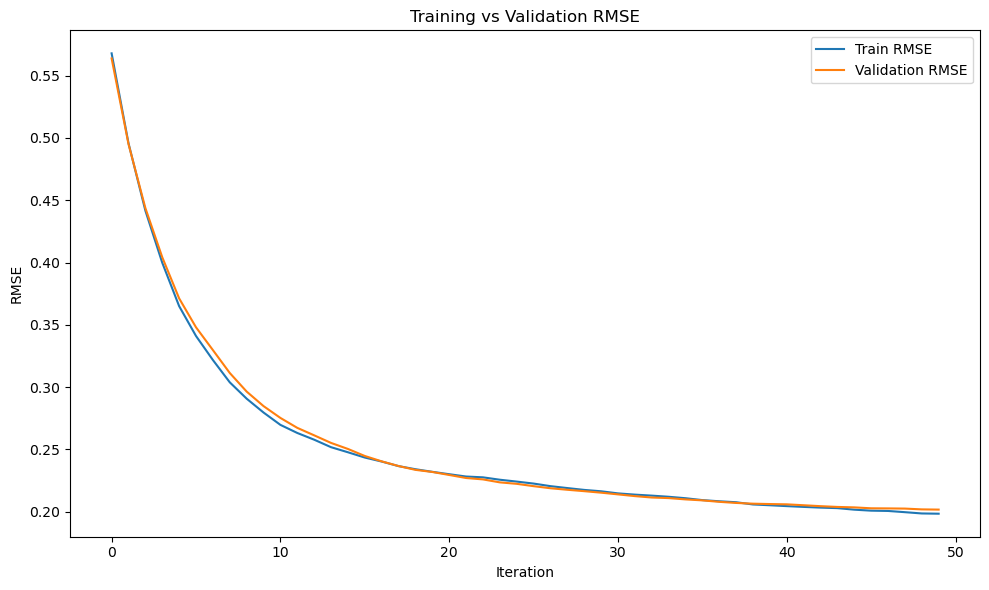

In [22]:
# Learning Curve (Training vs Validation Loss) to detect overfitting/underfitting

# Access loss over iterations
train_error = model.get_evals_result()['learn']['RMSE']
val_error = model.get_evals_result()['validation']['RMSE']

plt.figure(figsize=(10,6))
plt.plot(train_error, label='Train RMSE')
plt.plot(val_error, label='Validation RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training vs Validation RMSE')
plt.legend()
plt.tight_layout()
plt.show()

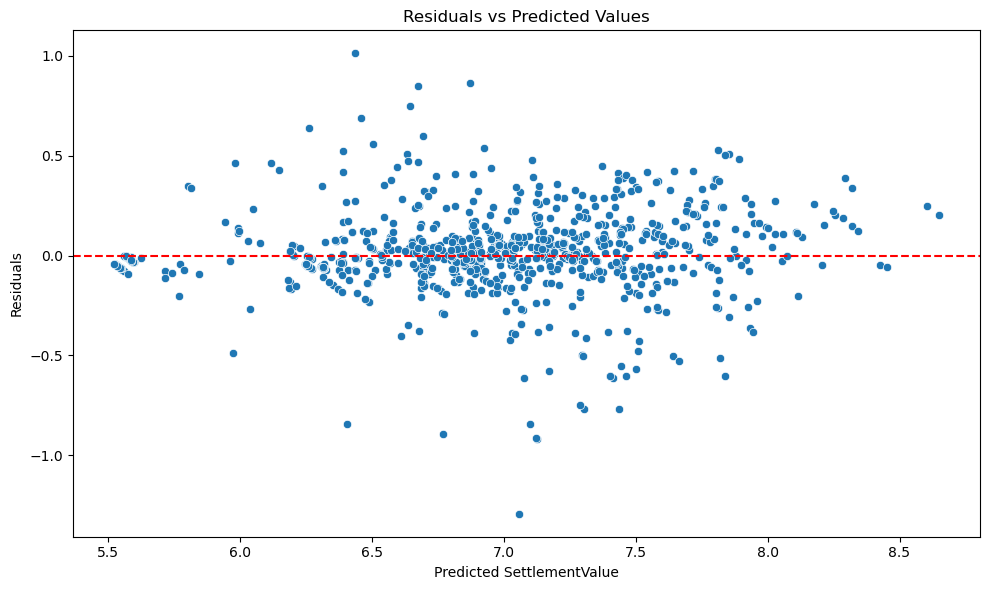

In [23]:
# Residuals vs Predicted Values to spot patterns in errors
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted SettlementValue')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.tight_layout()
plt.show()

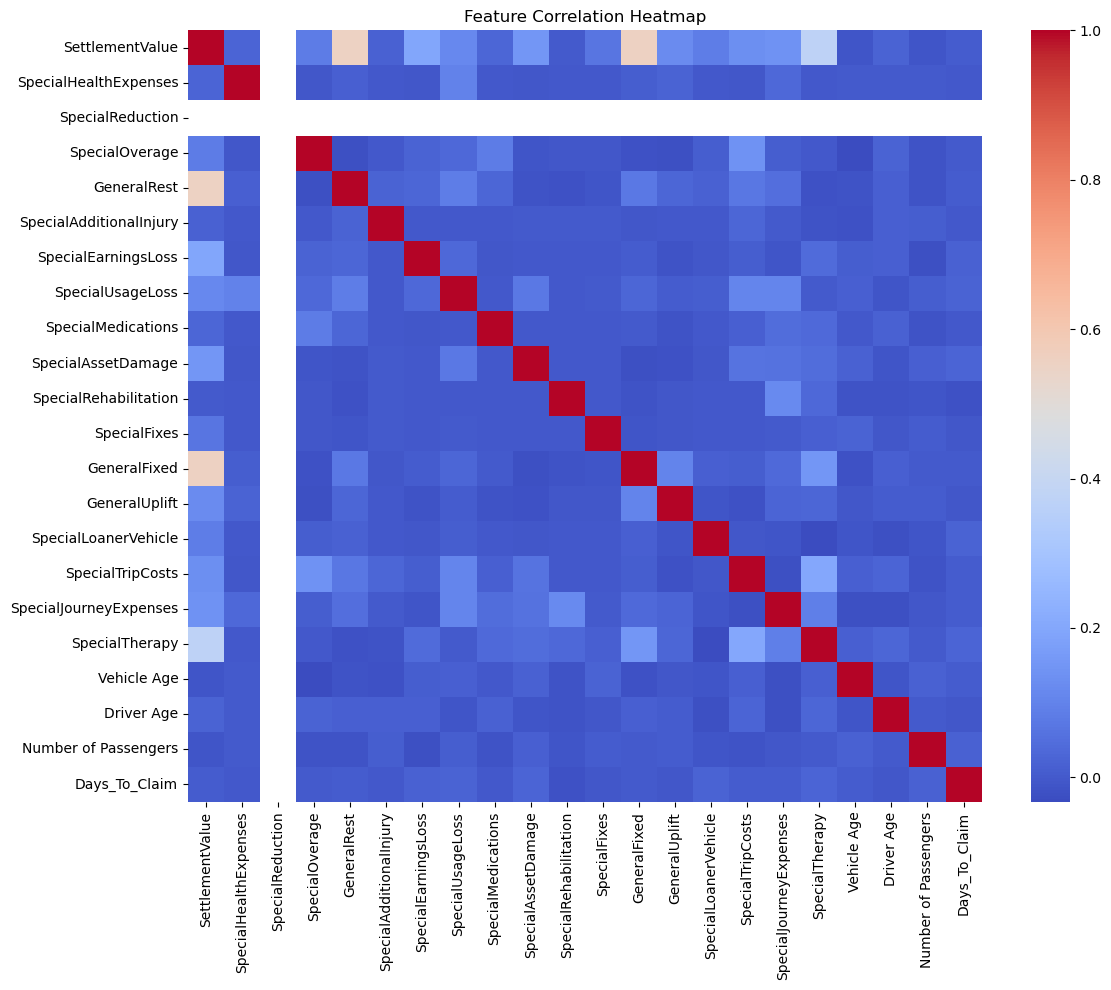

In [24]:
# Feature Correlation Heatmap to understand feature relationships
plt.figure(figsize=(12,10))

# Use only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])

# Calculate correlation matrix
corr = numeric_df.corr()

sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

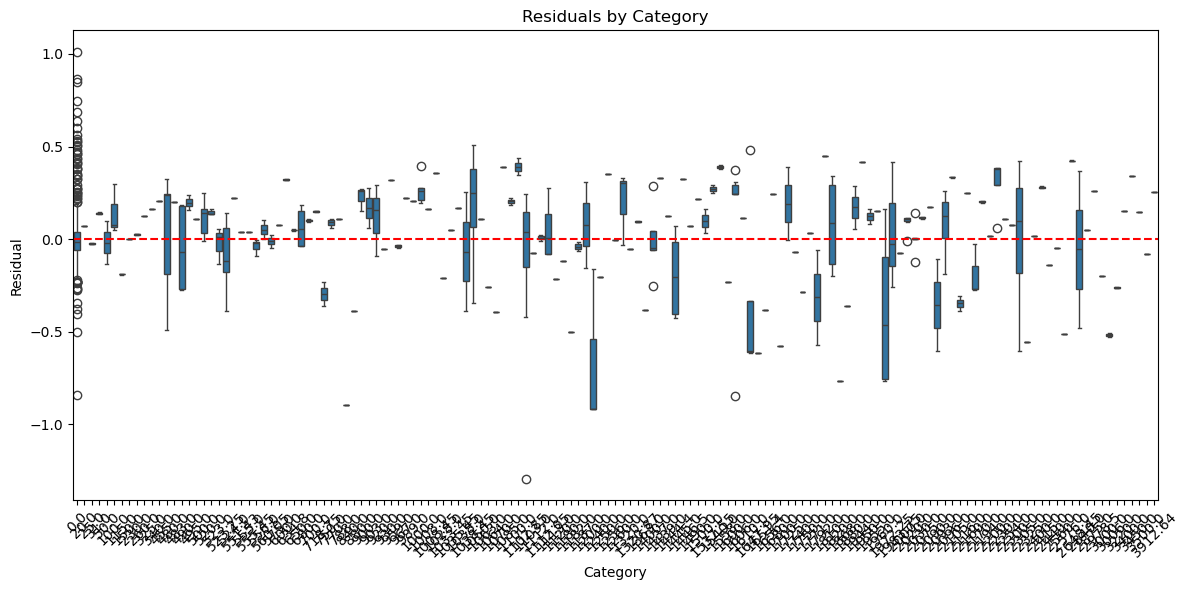

In [25]:
# Error Distribution by Categorical Variables for error analysis across groups
df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_results['Residual'] = df_results['Actual'] - df_results['Predicted']
df_results['Category'] = X_test['GeneralRest'] 

plt.figure(figsize=(12,6))
sns.boxplot(x='Category', y='Residual', data=df_results)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals by Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
# ---------------------------------
# GridSearch Results
# ---------------------------------

# # Define the model
# model = CatBoostRegressor(loss_function='RMSE', verbose=0)

# # Define the parameter grid to search over
# param_grid = {
#     # 'iterations': [100, 200, 300],
#     # 'depth': [4, 6, 8, 10],
#     # 'learning_rate': [0.01, 0.03, 0.1, 0.2],
#     # 'l2_leaf_reg': [1, 3, 5, 7, 10],
#     # 'random_strength': [1, 2, 3, 4, 5],
#     # 'one_hot_max_size': [5, 10],
    
#     'iterations': [50, 100, 200, 300],
#     'depth': [4, 6, 8, 10],
#     'learning_rate': [0.01, 0.03, 0.1, 0.2],
#     'l2_leaf_reg': [1, 3],
#     'random_strength': [1, 2],
#     'one_hot_max_size': [5],
# }

# # Set up the GridSearchCV
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)

# # Fit the grid search
# grid_search.fit(X_train, y_train, cat_features=cat_features)

# # Print best parameters from the grid search
# print("Best parameters found: ", grid_search.best_params_)

# # Get the best model
# best_model = grid_search.best_estimator_

# # Make predictions using the best model
# y_pred = best_model.predict(X_test)

# # Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# mae = mean_absolute_error(y_test, y_pred)

# # Calculate R2 (Coefficient of Determination)
# ss_total = np.sum((y_test - np.mean(y_test))**2)  # Total sum of squares
# ss_residual = np.sum((y_test - y_pred)**2)  # Residual sum of squares
# r2 = 1 - (ss_residual / ss_total)

# # Print the results
# print(f"\nModel Evaluation:")
# print(f"RMSE: {rmse:.2f}")
# print(f"MAE: {mae:.2f}")
# print(f"R2: {r2:.4f}")